# Benchmark of different dynamical-decoupling schemes

The goal if this notebook is to benchmark the different dynamical decoupling schemes on different initial states in order to be able to pick the best one.

## Backend initialisation

In [1]:
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Load IBMQ Account data
from qiskit import IBMQ
IBMQ.load_account()

# Get backend for experiment
provider = IBMQ.get_provider(hub='ibm-q-france', group='univ-montpellier', project='default') 
backend = provider.get_backend('ibmq_toronto')
properties = backend.properties()
configuration = backend.configuration()
defaults = backend.defaults()

## Initial states

We are interested in the improvements of using a given dynamical-decoupling sequence to increase the quantum state lifetime. In order to benchmark we need to define the quantum states we want to protect.

In [2]:
from typing import List
from qiskit import QuantumCircuit

benchmarked_initial_states: List[QuantumCircuit] = list()
initial_states_names: List[str] = list()

### Fundamental state $\vert 0 \rangle$

The fundamental state $\vert 0 \rangle$ has shown an impressive resistance to noise in our preliminary benchmarks: dynamical-decoupling sequences were only adding errors due to gate imprecisions and were degrading the quantum state fidelity. 

This state will not be benchmarked.

### Superposition state $\frac{\vert 0 \rangle + \vert 1 \rangle}{\sqrt{2}}$

The superposed state $\frac{\vert 0 \rangle + \vert 1 \rangle}{\sqrt{2}}$ is of particular interest because this is the kind of state that is subject to the most environmental noise: both relaxation and dephasing.
Moreover, dynamical-decoupling schemes tested are all devised for pure-dephasing noise, so are specifically targeted at this kind of states.

So $H$ is implemented as above.

In [3]:
from math import pi

h_initialisation = QuantumCircuit(1, name="hadamard")
h_initialisation.h(0)

benchmarked_initial_states.append((h_initialisation, h_initialisation.inverse()))
initial_states_names.append(r"$\frac{\vert 0 \rangle + \vert 1 \rangle}{\sqrt{2}}$")

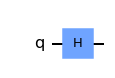

In [4]:
h_initialisation.draw("mpl")

### Bell state

In our special case of graph-state construction, we want to protect Bell-like states. The Bell-state is
$$
\frac{\vert 00 \rangle + \vert 11 \rangle}{\sqrt{2}}.
$$

Note that the optimised implementation of $H$ used here can be found above.

In [5]:
bell_state = QuantumCircuit(2, name="bell_state")
bell_state.h(0)
bell_state.cx(0, 1)

bell_state_inverse = QuantumCircuit(2, name="bell_state_inverse")
bell_state_inverse.cx(0, 1)
bell_state_inverse.h(0)

benchmarked_initial_states.append((bell_state, bell_state_inverse))
initial_states_names.append(r"$\frac{\vert 00 \rangle + \vert 11 \rangle}{\sqrt{2}}$")

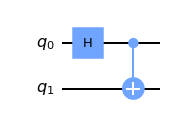

In [6]:
bell_state.draw("mpl")

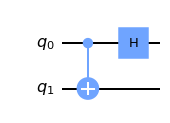

In [7]:
bell_state_inverse.draw("mpl")

## Dynamical decoupling sequences

We want to benchmark the most dynamical decoupling sequence possible in order to devise their effectiveness in protecting the quantum states.

In [8]:
from qiskit.ignis.mitigation.dd.sequence import BaseDynamicalDecouplingSequence

dd_sequences: List[BaseDynamicalDecouplingSequence] = list()
dd_names: List[str] = list()

### No dynamical-decoupling

A quick hack to be able to use "nothing" as a dynamical decoupling scheme (i.e. only delay).

In [9]:
from qiskit.ignis.mitigation.dd.components import DynamicalDecouplingDelayComponent

class NoDynamicalDecouplingSequence(BaseDynamicalDecouplingSequence):
    def __init__(self):    
        super(NoDynamicalDecouplingSequence, self).__init__(
            sequence=[DynamicalDecouplingDelayComponent()],
            relative_scales=[1]
        )

dd_sequences.append(NoDynamicalDecouplingSequence())
dd_names.append("none")

### Simple Hahn Echo Spin

The first sequence to be benchmarked is the Hahn-echo sequence, consisting of one $\pi$ pulse that rotates around the $X$-axis.

In [10]:
from qiskit.ignis.mitigation.dd.sequences import HahnSpinEchoDynamicalDecouplingSequence

hahn_sequence = HahnSpinEchoDynamicalDecouplingSequence(backend, add_pre_post_rotations=False)
dd_sequences.append(hahn_sequence)
dd_names.append("hahn")

### Carr-Purcell

The Carr-Purcell dynamical-decoupling sequence is a Hahn-echo sequence that is repeated several times. For this benchmark we empirically take $5$ repetitions.

In [11]:
from qiskit.ignis.mitigation.dd.sequences import CarrPurcellDynamicalDecouplingSequence

repetition_number = 5
cp_sequence = CarrPurcellDynamicalDecouplingSequence(
    backend, repetition_number=repetition_number, add_pre_post_rotations=False
)
dd_sequences.append(cp_sequence)
dd_names.append("cp")

### Carr-Purcell-Meiboom-Gill

Same as Carr-Purcel sequence but with $Y$ gates instead of $X$ gates.

In [12]:
from qiskit.ignis.mitigation.dd.sequences import (
    CPMGGateDynamicalDecouplingSequence, 
    CPMGPulseDynamicalDecouplingSequence
)

cpmg_gate_sequence = CPMGGateDynamicalDecouplingSequence(
    backend, repetition_number=repetition_number, add_pre_post_rotations=False
)
dd_sequences.append(cpmg_gate_sequence)
dd_names.append("cpmg_gate")

cpmg_pulse_sequence = CPMGPulseDynamicalDecouplingSequence(
    backend, repetition_number=repetition_number, add_pre_post_rotations=False
)
dd_sequences.append(cpmg_pulse_sequence)
dd_names.append("cpmg_pulse")

### $XY-4$ 

Applying $X$ and $Y$ gates in sequence twice to mitigate dephasing noise. Robust to more complex dephasing noise as the qubit state rotates around $2$ axis.

In [13]:
from qiskit.ignis.mitigation.dd.sequences import (
    XY4DynamicalDecouplingSequence, 
    XY4PulseDynamicalDecouplingSequence
)

xy4_gate_sequence = XY4DynamicalDecouplingSequence(backend, symmetric=True)
dd_sequences.append(xy4_gate_sequence)
dd_names.append("xy4_gate")

xy4_pulse_sequence = XY4PulseDynamicalDecouplingSequence(backend, symmetric=True)
dd_sequences.append(xy4_pulse_sequence)
dd_names.append("xy4_pulse")

### Knill Dynamical Decoupling (KDD)

The KDD scheme uses robust sequences of pulses to implement the $XY-4$ scheme with robust $X$ and $Y$ gates.

In [14]:
from qiskit.ignis.mitigation.dd.sequences import XY4KDDDynamicalDecouplingSequence

xy4kdd_sequence = XY4KDDDynamicalDecouplingSequence(backend, symmetric=True)
dd_sequences.append(xy4kdd_sequence)
dd_names.append("kdd")

### Uhrig Dynamical Decoupling (UDD)

Uhrig dynamical decoupling scheme is the only one using non-constant delays. It is theoretically very good as it cancels errors to higher orders.

In [15]:
from qiskit.ignis.mitigation.dd.sequences import (
    UhrigGateDynamicalDecouplingSequence, 
    UhrigPulseDynamicalDecouplingSequence
)

uhrig_gate_sequence = UhrigGateDynamicalDecouplingSequence(
    backend, repetition_number=repetition_number, add_pre_post_rotations=False
)
dd_sequences.append(xy4_gate_sequence)
dd_names.append("uhrig_gate")

uhrig_pulse_sequence = UhrigPulseDynamicalDecouplingSequence(
    backend, repetition_number=repetition_number, add_pre_post_rotations=False
)
dd_sequences.append(xy4_pulse_sequence)
dd_names.append("uhrig_pulse")

### Creating the pass managers

Instead of dynamical-decoupling sequences it is easier to directly use the PassManager instances that will apply the different dynamical-decoupling sequences to the circuit.

In [16]:
from qiskit.ignis.mitigation.dd.passes import get_dd_pass_manager

dd_pass_managers = [get_dd_pass_manager(backend, ddseq) for ddseq in dd_sequences]

## Circuit construction

We need circuits that will cover a wide range of different dynamically decoupled delays for every initial state and every dynamical decoupling sequence.

In [17]:
dt = backend.configuration().dt
minimum_delay_s = 1e-6
maximum_delay_s = 20e-6
delay_samples = 20

minimum_delay_dt = round(minimum_delay_s / dt)
maximum_delay_dt = round(maximum_delay_s / dt)

In [18]:
import numpy
delay_durations = numpy.linspace(minimum_delay_dt, maximum_delay_dt, delay_samples, dtype=numpy.int)
delay_durations

array([ 4500,  9000, 13500, 18000, 22500, 27000, 31500, 36000, 40500,
       45000, 49500, 54000, 58500, 63000, 67500, 72000, 76500, 81000,
       85500, 90000])

In [19]:
from qiskit import transpile

circuits: List[QuantumCircuit] = list()
circuits_data = dict()

for ic, icinverse in benchmarked_initial_states:
    icn = ic.name
    circuits_data[icn] = dict()
    for ddname, ddseq in zip(dd_names, dd_sequences):
        circuits_data[icn][ddname] = list()
        for delay_duration in delay_durations:
            # We want to apply on the first qubits for the moment
            nqubits = ic.num_qubits
            qargs = tuple(range(nqubits))
            # Creating the dynamically-decoupled circuit
            circ = QuantumCircuit(configuration.num_qubits, nqubits)
            circ.append(ic.to_instruction(), qargs=qargs)
            for qarg in qargs:
                circ.compose(ddseq.circuit(delay_duration, [qarg]), qubits=[qarg], inplace=True)
            circ.append(icinverse.to_instruction(), qargs=qargs)
            circ.measure(qargs, qargs)
            circuits.append(transpile(circ, backend, optimization_level=0))
            circuits_data[icn][ddname].append(circuits[-1])
print(f"Constructed {len(circuits)} circuits.")

Constructed 400 circuits.


## Circuit execution

We now want to execute the circuits on the backend. Pulse gates in circuits are now supported on some backends (see list [here](https://qiskit.org/documentation/tutorials/circuits_advanced/05_pulse_gates.html)) so we do not have to change our circuit to a `Schedule`.

In [21]:
from qiskit import execute

job = execute(
    circuits, backend, shots=8192, 
    initial_layout=list(range(configuration.num_qubits)), 
    optimization_level=0
)

# min: 1e-6 max: 20e-6 n: 30
# job = backend.retrieve_job("60535c3668a5a25729827f41")
# min: 1e-6 max: 10e-6 n: 20 backend: toronto optimized H
#job = backend.retrieve_job("605b34d9ef04bbb9655f9dd3")
# min: 1e-6 max: 10e-6 n: 20 backend: toronto normal H
#job = backend.retrieve_job("605b3efe11fac4a7bc943968")
print(job.job_id())

605b3efe11fac4a7bc943968


In [22]:
from qiskit.tools import job_monitor
job_monitor(job)

Job Status: job has successfully run


In [23]:
results = job.result()
i = 0

data = dict()
all_counts = dict()

for initialisation_circuit, initialisation_circuit_inverse in benchmarked_initial_states:
    icn = initialisation_circuit.name
    data[icn] = dict()
    all_counts[icn] = dict()
    for ddname in dd_names:
        data[icn][ddname] = list()
        all_counts[icn][ddname] = list()
        for delay_duration in delay_durations:
            counts = results.get_counts(i)
            all_counts[icn][ddname].append(counts)
            data[icn][ddname].append(counts.int_outcomes().get(0, 0) / 8192)
            i += 1

Because of the fact that we used $5$ repetitions, the CPMG and Uhrig sequences that are using $Y$ gates will flip the expected result for the hadamard initialised circuit. We correct this virtually in the fidelities.

In [31]:
data["hadamard"]["cpmg_gate"] = [1 - d for d in data["hadamard"]["cpmg_gate"]]
data["hadamard"]["cpmg_pulse"] = [1 - d for d in data["hadamard"]["cpmg_pulse"]]
#data["hadamard"]["uhrig_gate"] = [1 - d for d in data["hadamard"]["uhrig_gate"]]
#data["hadamard"]["uhrig_pulse"] = [1 - d for d in data["hadamard"]["uhrig_pulse"]]

In order to save the data for possibly re-using it, let's use pickle!

In [ ]:
from random import randint

filename = f"dd_data_{minimum_delay_s:.0e}_{maximum_delay_s:.0e}_{delay_samples}.pkl"
filename

In [ ]:
import pickle

with open(filename, "wb") as f:
    pickle.dump(data, f)

## Plot the results

In [ ]:
import pickle 

with open(filename, "rb") as f:
    data = pickle.load(f)

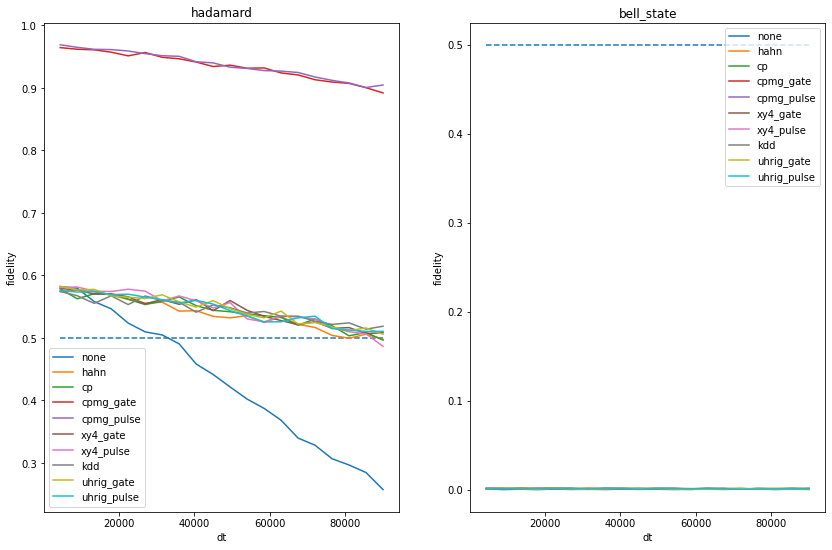

In [32]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(
    nrows=1, ncols=len(benchmarked_initial_states), 
    figsize=(14, 9)
)

for i, ((ic, ic_inverse), iclabel) in enumerate(zip(benchmarked_initial_states, initial_states_names)):
    ax = axes[i]
    icn = ic.name
    for ddname in dd_names:
        if ddname in data[icn] and data[icn][ddname]:
            ax.plot(delay_durations, data[icn][ddname], label=ddname)
    ax.hlines(0.5, xmin=delay_durations[0], xmax=delay_durations[-1], linestyles="dashed")
    ax.set_title(icn)
    ax.legend()
    ax.set_xlabel("dt")
    ax.set_ylabel("fidelity")

fig.show()

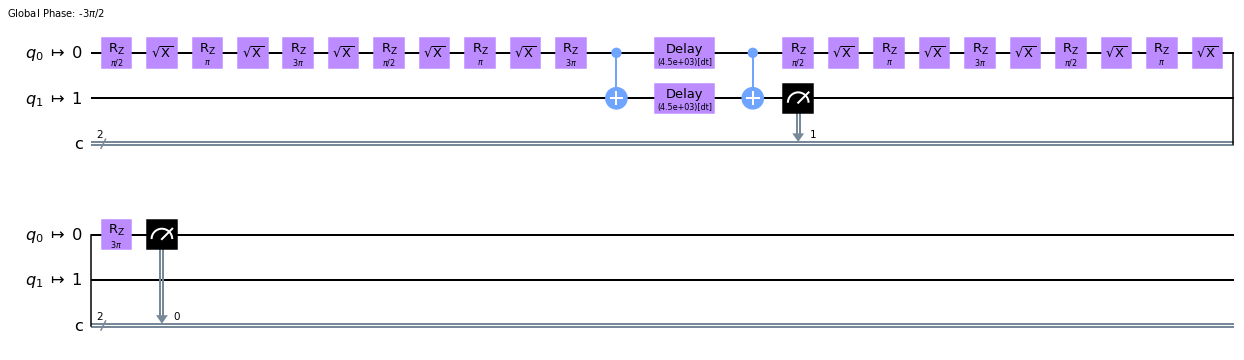

In [39]:
circuits_data["bell_state"]["none"][0].draw("mpl", idle_wires=False)

In [ ]:
from qiskit import Aer, execute
from qiskit.providers.aer import QasmSimulator

sim = QasmSimulator()
res = execute(circuits_data["hadamard"]["none"][0], sim).result()
res.get_counts()

In [ ]:
job_backend = execute(
    circuits_data["hadamard"]["none"][0], 
    backend, 
    optimization_level=0, 
    shots=8192, 
    initial_layout=list(range(configuration.num_qubits))
)
job_monitor(job_backend)

In [ ]:
res_backend = job_backend.result()
res_backend.get_counts()

In [40]:
all_counts["bell_state"]["none"][0]

{'00': 5, '01': 7, '10': 4240, '11': 3940}